In [1]:
# Imports and Configuration
import struct
import numpy as np
import pyshark
import pandas as pd
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, List, Optional
import nest_asyncio
from collections import defaultdict, deque
import struct
from typing import List, Tuple, Optional

nest_asyncio.apply()

# Configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


# Exp 1: number of features and windown size

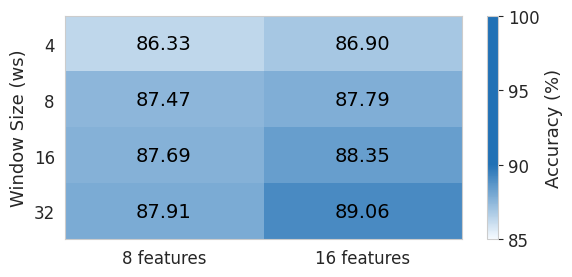

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Data
ws = [4, 8, 16, 32]
features = ['8 features', '16 features']

accuracy = np.array([
    [86.3281, 86.8983],
    [87.4732, 87.7856],
    [87.6871, 88.3481],
    [87.9105, 89.0584]
])

# ---- Custom hex colormap ----
hex_colors = [
    "#f7fbff",  # very light
    "#2171b5",
    "#2171b5",
    "#2171b5"   # dark
]

cmap = LinearSegmentedColormap.from_list(
    "custom_blue", hex_colors
)

plt.rcParams.update({
    "font.size": 14,          # base font size
    "axes.labelsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    # "colorbar.labelsize": 10
})

# Figure
plt.figure(figsize=(6, 3))

# Heatmap (no grid by default in imshow)
im = plt.imshow(
    accuracy,
    aspect='auto',
    cmap=cmap,
    vmin=85,
    vmax=100,
    interpolation='nearest'
)

ax = plt.gca()
ax.grid(False)
ax.minorticks_off()


# Axis labels
# plt.xlabel('Feature Set')
plt.ylabel('Window Size (ws)')

# Ticks
plt.xticks(np.arange(len(features)), features)
plt.yticks(np.arange(len(ws)), ws)

# Colorbar with controlled ticks
cbar = plt.colorbar(im, ticks=[85, 90, 95, 100])
cbar.set_label('Accuracy (%)', fontsize=13)

# Annotate cells
for i in range(len(ws)):
    for j in range(len(features)):
        plt.text(
            j, i,
            f"{accuracy[i, j]:.2f}",
            ha="center", va="center",
            color="black"
        )

# Remove spines for cleaner look
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)

# Layout & save
plt.tight_layout()
# plt.savefig('exp1_nf_ws/nf_ws_accuracy.pdf', dpi=300)

plt.show()


# Exp 2: accuracy at different tree sizes and window sizesfor RF wih 8 features  

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RESULTS_CSV = "../training_results/exp2_tree_size/rf_grid_search_results.csv"
OUT_DIR = "plots"
os.makedirs(OUT_DIR, exist_ok=True)

def summarize_from_df(results_df):
    # Basic cleaning & types
    results_df['max_depth'] = results_df['max_depth'].replace('None', None)
    # some CSVs may have depth as string; coerce gracefully
    results_df['max_depth'] = pd.to_numeric(results_df['max_depth'], errors='coerce').astype('Int64')
    results_df['n_estimators'] = pd.to_numeric(results_df['n_estimators'], errors='coerce').astype(int)
    results_df['accuracy'] = pd.to_numeric(results_df['accuracy'], errors='coerce')
    if 'roc_auc' in results_df.columns:
        results_df['roc_auc'] = pd.to_numeric(results_df['roc_auc'], errors='coerce')

    # 1) Average accuracy per dataset
    summary = (
        results_df.groupby("dataset")["accuracy"]
        .agg(["mean", "std", "count"])
        .rename(columns={"mean": "avg_accuracy", "std": "std_accuracy", "count": "n_configs"})
        .reset_index()
    )

    # Keep dataset ordering by numeric suffix if present (ws4, ws8...)
    def extract_num(ds):
        import re
        m = re.search(r'(\d+)', ds)
        return int(m.group(1)) if m else 0
    summary['dataset_num'] = summary['dataset'].apply(extract_num)
    summary = summary.sort_values('dataset_num').reset_index(drop=True)

    print("\nAverage accuracy per dataset (sorted by dataset_num):")
    print(summary[['dataset', 'avg_accuracy', 'std_accuracy', 'n_configs']].to_string(index=False, float_format="%.6f"))

    # Bar plot with error bars (average accuracy ± std)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(summary['dataset'], summary['avg_accuracy'], yerr=summary['std_accuracy'],
           capsize=5, alpha=0.85)
    ax.set_ylabel("Average accuracy")
    ax.set_ylim(0, 1.0)
    ax.set_title("Average accuracy per dataset (with std dev)")
    for i, v in enumerate(summary['avg_accuracy']):
        ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)
    plt.tight_layout()
    barpath = os.path.join(OUT_DIR, "avg_accuracy_per_dataset.png")
    plt.savefig(barpath, dpi=200)
    print(f"Saved bar plot to {barpath}")
    plt.close(fig)

    return summary

def plot_heatmaps(results_df):
    # create a heatmap per dataset showing roc_auc (rows: n_estimators, cols: max_depth)
    if 'roc_auc' not in results_df.columns:
        print("No 'roc_auc' column found in CSV — skipping heatmaps.")
        return

    datasets = sorted(results_df['dataset'].unique(), key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
    for ds in datasets:
        df = results_df[results_df['dataset'] == ds].copy()
        # pivot: rows=n_estimators, cols=max_depth, values=roc_auc (mean if multiple)
        pivot = df.pivot_table(index='n_estimators', columns='max_depth', values='roc_auc', aggfunc='mean')
        if pivot.empty:
            print(f"Empty pivot for {ds}, skipping.")
            continue

        plt.figure(figsize=(8, 5))
        sns.heatmap(pivot, annot=True, fmt=".3f", linewidths=.5, cbar_kws={'label': 'ROC-AUC'}, cmap="viridis")
        plt.title(f"ROC-AUC heatmap — {ds} (rows=n_estimators, cols=max_depth)")
        plt.ylabel("n_estimators")
        plt.xlabel("max_depth")
        plt.tight_layout()
        heatpath = os.path.join(OUT_DIR, f"roc_auc_heatmap_{ds}.png")
        plt.savefig(heatpath, dpi=200)
        print(f"Saved heatmap for {ds} to {heatpath}")
        plt.close()

def plot_grouped_bars(results_df):
    """
    Produce grouped bar plots for each dataset:
      - accuracy (bars grouped by n_estimators, colored by max_depth)
      - roc_auc (if present)
      - avg_nodes_per_tree (log scale) vs n_estimators grouped by depth
      - fp/fn (if present)
    All plots saved to OUT_DIR.
    """
    datasets_sorted = sorted(results_df['dataset'].unique(), key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
    # Determine global sorted depths and estimators to keep consistent ordering across subplots
    global_depths = sorted(results_df['max_depth'].dropna().unique())
    global_estimators = sorted(results_df['n_estimators'].dropna().unique())

    # Helper to make grouped bar plot for a given metric
    def _grouped_bar_for_metric(metric, ylabel, filename_suffix, log_scale=False, value_fmt="{:.3f}"):
        for ds in datasets_sorted:
            df = results_df[results_df['dataset'] == ds].copy()
            if df.empty:
                print(f"No data for {ds}, skipping {metric}.")
                continue

            # prepare pivot: rows=n_estimators, cols=max_depth -> mean(metric)
            pivot = df.pivot_table(index='n_estimators', columns='max_depth', values=metric, aggfunc='mean')
            # reindex rows and columns to global ordering (fill missing with NaN)
            pivot = pivot.reindex(index=global_estimators, columns=global_depths)
            # plotting
            n_groups = len(pivot.index)
            n_depths = len(pivot.columns)
            bar_width = 0.8 / max(1, n_depths)  # keep bars within group width
            x = np.arange(n_groups)

            fig, ax = plt.subplots(figsize=(10, 5))
            for i, depth in enumerate(pivot.columns):
                vals = pivot[depth].values
                ax.bar(x + i * bar_width, vals, width=bar_width, label=f"depth={int(depth)}")

            ax.set_xticks(x + bar_width * (n_depths - 1) / 2)
            ax.set_xticklabels(pivot.index.astype(str))
            ax.set_xlabel("n_estimators")
            ax.set_ylabel(ylabel)
            ax.set_title(f"{ds} — {ylabel} by n_estimators and max_depth")
            ax.grid(True, axis='y', linestyle='--', alpha=0.4)
            ax.legend(title="max_depth", fontsize=8)
            if log_scale:
                ax.set_yscale('log')
            # annotate top of bars with values (optional: skip NaN)
            for i in range(n_groups):
                for j in range(n_depths):
                    val = pivot.iloc[i, j]
                    if pd.notna(val):
                        ax.text(x[i] + j * bar_width, val + (0 if log_scale else 0.005), value_fmt.format(val),
                                ha='center', va='bottom', fontsize=7, rotation=90 if n_depths>6 else 0)

            plt.tight_layout()
            out_path = os.path.join(OUT_DIR, f"{ds}_{filename_suffix}.png")
            plt.savefig(out_path, dpi=180)
            print(f"Saved {metric} grouped bar plot for {ds} to {out_path}")
            plt.close()

    # Accuracy bars
    _grouped_bar_for_metric(metric='accuracy', ylabel='Accuracy', filename_suffix='accuracy_grouped_bars', log_scale=False)

    # ROC-AUC bars (if present)
    if 'roc_auc' in results_df.columns:
        _grouped_bar_for_metric(metric='roc_auc', ylabel='ROC-AUC', filename_suffix='roc_auc_grouped_bars', log_scale=False)

    # avg_nodes_per_tree bars (if present) — use log scale for readability
    if 'avg_nodes_per_tree' in results_df.columns:
        _grouped_bar_for_metric(metric='avg_nodes_per_tree',
                                ylabel='avg_nodes_per_tree (log)',
                                filename_suffix='avg_nodes_grouped_bars',
                                log_scale=True,
                                value_fmt="{:.0f}")

    # total_nodes bars (if present) — log scale
    if 'total_nodes' in results_df.columns:
        _grouped_bar_for_metric(metric='total_nodes',
                                ylabel='total_nodes (log)',
                                filename_suffix='total_nodes_grouped_bars',
                                log_scale=True,
                                value_fmt="{:.0f}")

    # FP/FN grouped bars if available
    if all(c in results_df.columns for c in ['fp', 'fn']):
        # For operational view, create side-by-side fp & fn plots
        for ds in datasets_sorted:
            df = results_df[results_df['dataset'] == ds].copy()
            if df.empty:
                continue
            # pivot for fp and fn
            pivot_fp = df.pivot_table(index='n_estimators', columns='max_depth', values='fp', aggfunc='mean').reindex(index=global_estimators, columns=global_depths)
            pivot_fn = df.pivot_table(index='n_estimators', columns='max_depth', values='fn', aggfunc='mean').reindex(index=global_estimators, columns=global_depths)

            n_groups = len(global_estimators)
            n_depths = len(global_depths)
            bar_width = 0.8 / max(1, n_depths)
            x = np.arange(n_groups)

            fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
            for i, depth in enumerate(global_depths):
                axes[0].bar(x + i * bar_width, pivot_fp[depth].values, width=bar_width, label=f"d={int(depth)}")
                axes[1].bar(x + i * bar_width, pivot_fn[depth].values, width=bar_width, label=f"d={int(depth)}")

            for ax, metric_name in zip(axes, ['False Positives (fp)', 'False Negatives (fn)']):
                ax.set_xticks(x + bar_width * (n_depths - 1) / 2)
                ax.set_xticklabels([str(e) for e in global_estimators])
                ax.set_xlabel("n_estimators")
                ax.set_title(f"{ds} — {metric_name} by n_estimators and depth")
                ax.grid(True, axis='y', linestyle='--', alpha=0.4)
            axes[0].set_ylabel("count")
            axes[0].legend(title="max_depth", fontsize=8)
            out_path = os.path.join(OUT_DIR, f"{ds}_fp_fn_grouped_bars.png")
            plt.tight_layout()
            plt.savefig(out_path, dpi=180)
            print(f"Saved fp/fn grouped bars for {ds} to {out_path}")
            plt.close()

if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Results CSV not found: {RESULTS_CSV}. Place the CSV in the script directory.")

df = pd.read_csv(RESULTS_CSV)
summary = summarize_from_df(df)
plot_heatmaps(df)
plot_grouped_bars(df)



Average accuracy per dataset (sorted by dataset_num):
dataset  avg_accuracy  std_accuracy  n_configs
    ws4      0.828346      0.037578         25
    ws8      0.833598      0.043600         25
   ws16      0.838408      0.037851         25
   ws32      0.843237      0.037116         25
Saved bar plot to plots/avg_accuracy_per_dataset.png
Saved heatmap for ws4 to plots/roc_auc_heatmap_ws4.png
Saved heatmap for ws8 to plots/roc_auc_heatmap_ws8.png
Saved heatmap for ws16 to plots/roc_auc_heatmap_ws16.png
Saved heatmap for ws32 to plots/roc_auc_heatmap_ws32.png
Saved accuracy grouped bar plot for ws4 to plots/ws4_accuracy_grouped_bars.png
Saved accuracy grouped bar plot for ws8 to plots/ws8_accuracy_grouped_bars.png
Saved accuracy grouped bar plot for ws16 to plots/ws16_accuracy_grouped_bars.png
Saved accuracy grouped bar plot for ws32 to plots/ws32_accuracy_grouped_bars.png
Saved roc_auc grouped bar plot for ws4 to plots/ws4_roc_auc_grouped_bars.png
Saved roc_auc grouped bar plot for w

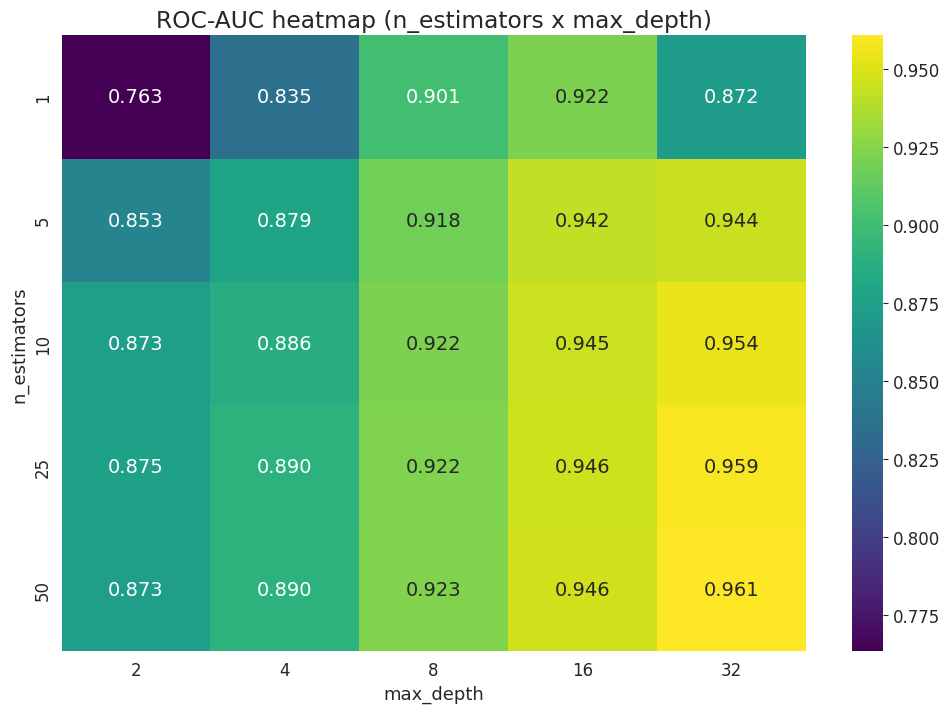

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('exp2_tree_size/rf_grid_search_results.csv')  # your CSV
pivot = df.pivot_table(index='n_estimators', columns='max_depth', values='roc_auc', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis')
plt.title('ROC-AUC heatmap (n_estimators x max_depth)')
plt.ylabel('n_estimators'); plt.xlabel('max_depth')
plt.show()

# Exp 3: SHAP

In [6]:
! pip install shap

     |████████████████████████████████| 538 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 23.8 MB/s  eta 0:00:01
     |████████████████████████████████| 74 kB 11.7 MB/s  eta 0:00:01
     |████████████████████████████████| 3.7 MB 119.9 MB/s eta 0:00:01
     |████████████████████████████████| 43.6 MB 108.2 MB/s eta 0:00:01


In [ ]:
# compute_shap_artifacts.py
import json
import joblib
import numpy as np
import pandas as pd
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# ----- 0) Your input dataframes should exist: df_normal, df_fault -----
# (They must be defined in the environment or imported before running this script.)

df_normal = pd.read_csv("../training_features/normal_ws8.csv")
df_fault = pd.read_csv("../training_features/fault_ws8.csv")

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr',
                'ewma_mean','ewma_min','ewma_max','ewma_range',
                'cusum_mean','cusum_min','cusum_max','cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']

# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# Train Random Forest
rf_model = RandomForestClassifier(
    max_depth=32,
    n_estimators=50,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# sklearn feature importances
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': numeric_cols, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
print("\n(b) sklearn Feature Importances")
print(feature_importances)

print("\nDone.")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64
(a) Model Evaluation
Accuracy on test data: 0.894943
              precision    recall  f1-score   support

           0     0.9126    0.8536    0.8821      3169
           1     0.8816    0.9302    0.9053      3713

    accuracy                         0.8949      6882
   macro avg     0.8971    0.8919    0.8937      6882
weighted avg     0.8959    0.8949    0.8946      6882

Confusion matrix:
[[2705  464]
 [ 259 3454]]
ROC AUC: 0.9641355451839235

(b) sklearn Feature Importances
       feature  importance
0  mean_iat_us    0.320551
1   iat_max_us    0.242104
2   iat_min_us    0.216451
3         mean    0.063601
4          min    0.053519
5          max    0.046213
6        slope    0.029337
7        range    0.028225

Done.


In [2]:
# -------------------------
# ---- SHAP Computation ----
# -------------------------
print("\n--- Computing SHAP values (TreeExplainer) ---")
explainer = shap.TreeExplainer(rf_model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)

# For binary classification, take positive class (index 1)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_pos = shap_values[1]   # shape: (n_samples, n_features)
    expected_value = explainer.expected_value[1]
else:
    shap_pos = shap_values
    try:
        expected_value = explainer.expected_value
    except Exception:
        # fallback
        expected_value = float(np.mean(rf_model.predict_proba(X_train)[:, 1]))

# Global mean absolute SHAP
mean_abs_shap = np.mean(np.abs(shap_pos), axis=0)
shap_df = pd.DataFrame({'feature': numeric_cols, 'mean_abs_shap': mean_abs_shap})
shap_df = shap_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print("\n(c) Mean absolute SHAP values (feature ranking)")
print(shap_df)

# Save artifacts for plotting later
out_prefix = "shap_artifacts"
joblib.dump(rf_model, "model.pkl")
pd.to_pickle(X_test, "X_test.pkl")
pd.to_pickle(y_test, "y_test.pkl")
np.save("shap_pos.npy", shap_pos)
np.save("expected_value.npy", np.array([expected_value]))  # saved as array for easy load
with open("numeric_cols.json", "w") as f:
    json.dump(numeric_cols, f)
feature_importances.to_csv("feature_importances.csv", index=False)
shap_df.to_csv("shap_df.csv", index=False)

# Save a CSV with SHAP values for one example (index 0) for quick glance
example_idx = 0
sample_shap = pd.DataFrame({
    'feature': numeric_cols,
    'shap_value': shap_pos[example_idx],
    'feature_value': X_test.iloc[example_idx].values
}).sort_values('shap_value', key=lambda x: x.abs(), ascending=False)
sample_shap.to_csv(f"sample_shap_example_{example_idx}.csv", index=False)

print("\nSaved artifacts:")
print("- model.pkl")
print("- X_test.pkl")
print("- y_test.pkl")
print("- shap_pos.npy")
print("- expected_value.npy")
print("- numeric_cols.json")
print("- feature_importances.csv")
print("- shap_df.csv")
print(f"- sample_shap_example_{example_idx}.csv")


--- Computing SHAP values (TreeExplainer) ---

(c) Mean absolute SHAP values (feature ranking)
       feature  mean_abs_shap
0  mean_iat_us       0.139060
1   iat_min_us       0.101381
2   iat_max_us       0.094720
3          min       0.039228
4         mean       0.034494
5          max       0.027854
6        range       0.022891
7        slope       0.011045

Saved artifacts:
- model.pkl
- X_test.pkl
- y_test.pkl
- shap_pos.npy
- expected_value.npy
- numeric_cols.json
- feature_importances.csv
- shap_df.csv
- sample_shap_example_0.csv


Saving SHAP summary plot to 'shap_summary.png' ...
Saving SHAP waterfall plot for test sample index 0 to 'shap_force_sample_0.png' ...


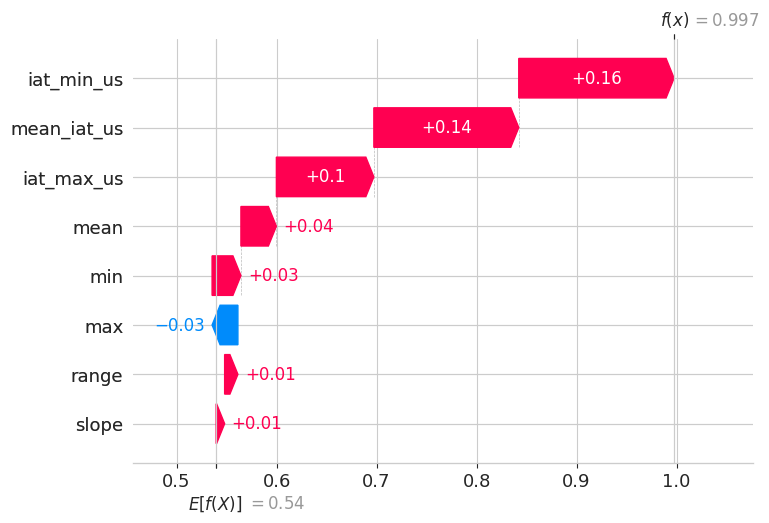

Saving SHAP dependence plot for top feature 'mean_iat_us' to 'shap_dependence_mean_iat_us.png' ...
Plots created:
- shap_summary.png
- shap_force_sample_0.png
- shap_dependence_mean_iat_us.png
Done.


<Figure size 700x500 with 0 Axes>

In [33]:
# plot_shap_artifacts.py
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap

# Load artifacts
rf_model = joblib.load("exp3_shap/8f/model.pkl")           # not strictly required for plotting but kept for completeness
X_test = pd.read_pickle("exp3_shap/8f/X_test.pkl")
y_test = pd.read_pickle("exp3_shap/8f/y_test.pkl")
shap_pos = np.load("exp3_shap/8f/shap_pos.npy")            # (n_samples, n_features) for positive class
expected_value = float(np.load("exp3_shap/8f/expected_value.npy")[0])

with open("exp3_shap/8f/numeric_cols.json", "r") as f:
    numeric_cols = json.load(f)

shap_df = pd.read_csv("exp3_shap/8f/shap_df.csv")
feature_importances = pd.read_csv("exp3_shap/8f/feature_importances.csv")

# --- SHAP summary plot (global) ---
print("Saving SHAP summary plot to 'shap_summary.png' ...")
plt.figure(figsize=(8,6))
shap.summary_plot(shap_pos, X_test, feature_names=numeric_cols, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=150)
plt.close()

# --- Local explanation: waterfall / force plot for one example ---
example_idx = 0  # change as desired
print(f"Saving SHAP waterfall plot for test sample index {example_idx} to 'shap_force_sample_{example_idx}.png' ...")
plt.figure(figsize=(8,3))
# waterfall_legacy accepts expected_value, shap_values, ... 
shap.plots._waterfall.waterfall_legacy(expected_value, shap_pos[example_idx], feature_names=numeric_cols, max_display=15)
plt.tight_layout()
plt.savefig(f"shap_force_sample_{example_idx}.png", dpi=150)
plt.close()

# --- Dependence plot for top feature (from shap_df) ---
top_feature = shap_df.loc[0, 'feature']
print(f"Saving SHAP dependence plot for top feature '{top_feature}' to 'shap_dependence_{top_feature}.png' ...")
plt.figure(figsize=(7,5))
# shap.dependence_plot expects the name of the feature or column index; pass in name and use shap_pos aligned with X_test
shap.dependence_plot(top_feature, shap_pos, X_test, feature_names=numeric_cols, show=False)
plt.tight_layout()
plt.savefig(f"shap_dependence_{top_feature}.png", dpi=150)
plt.close()

print("Plots created:")
print("- shap_summary.png")
print(f"- shap_force_sample_{example_idx}.png")
print(f"- shap_dependence_{top_feature}.png")
print("Done.")


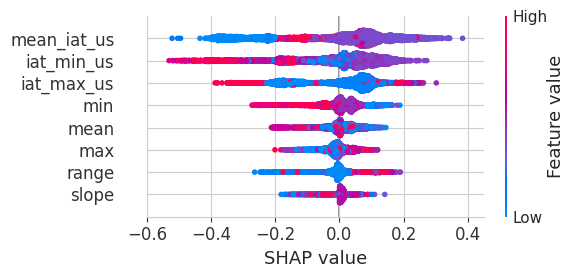

In [78]:
# plot_shap_artifacts.py
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap

# Load artifacts
rf_model = joblib.load("exp3_shap/8f/model.pkl")           # not strictly required for plotting but kept for completeness
X_test = pd.read_pickle("exp3_shap/8f/X_test.pkl")
y_test = pd.read_pickle("exp3_shap/8f/y_test.pkl")
shap_pos = np.load("exp3_shap/8f/shap_pos.npy")            # (n_samples, n_features) for positive class
expected_value = float(np.load("exp3_shap/8f/expected_value.npy")[0])

with open("exp3_shap/8f/numeric_cols.json", "r") as f:
    numeric_cols = json.load(f)

shap_df = pd.read_csv("exp3_shap/8f/shap_df.csv")
feature_importances = pd.read_csv("exp3_shap/8f/feature_importances.csv")

# --- SHAP summary plot (global) ---

# # Global font control (same as before)
# plt.rcParams.update({
#     "font.size": 14,
#     "axes.labelsize": 13,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12
# })

# Create SHAP plot without auto-show
shap.summary_plot(
    shap_pos,
    X_test,
    feature_names=numeric_cols,
    show=False
)

# Resize figure
plt.gcf().set_size_inches(6, 3)

ax = plt.gca()

# --- Axis limits & ticks ---
ax.set_xlim(-0.6, 0.45)
ax.set_xticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4])

# --- Force font sizes (SHAP-safe) ---
for label in ax.get_yticklabels():
    label.set_fontsize(12)

for label in ax.get_xticklabels():
    label.set_fontsize(12)

ax.set_xlabel("SHAP value", fontsize=13)
ax.xaxis.label.set_size(13)

plt.tight_layout()
fig = plt.gcf()
# --- Make colorbar thinner ---
cbar_ax = fig.axes[-1]
pos = cbar_ax.get_position()
cbar_ax.set_position([
    pos.x0,
    pos.y0,
    pos.width * 2,
    pos.height
])
cbar_ax.set_ylabel("Feature value", fontsize=13)

# Layout & save
plt.tight_layout()
plt.savefig("exp3_shap/shap_8f_8ws.pdf", dpi=300)
plt.show()